# Santa Workshop Tour competition

This notebook builds tailormade models to organize a tour schedule, based on data provided on the [Santa's Workshop Tour 2019 competition](https://www.kaggle.com/c/santa-workshop-tour-2019/).

In [99]:
# Load dependencies.
import numpy as np
import pandas as pd

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
import seaborn as sns

import locale
locale.setlocale(locale.LC_ALL, 'en_US')

'en_US'

## 1. Load data

In [77]:
# Load train and test data.
data = pd.read_csv('./data/family_data.csv', sep=',')
sample_submission = pd.read_csv('./data/sample_submission.csv', sep=',')

# Take a quick look into the data.
data.head(8)

,family_id,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
0,0,52,38,12,82,33,75,64,76,10,28,4
1,1,26,4,82,5,11,47,38,6,66,61,4
2,2,100,54,25,12,27,82,10,89,80,33,3
3,3,2,95,1,96,32,6,40,31,9,59,2
4,4,53,1,47,93,26,3,46,16,42,39,4
5,5,32,59,12,3,60,26,35,50,5,2,4
6,6,88,4,1,3,91,32,39,57,28,99,2
7,7,25,11,52,48,10,17,88,50,95,66,5


## 2. Explore data

In [78]:
# General stats.
print("Total number of families:", len(data))
print("Total number of visitors:", data['n_people'].sum())
print("Average people per family:", data['n_people'].sum()/len(data))
print("Average families per day:", len(data)/100)
print("Average people per day:", data['n_people'].sum()/100)

Total number of families: 5000
Total number of visitors: 21003
Average people per family: 4.2006
Average families per day: 50.0
Average people per day: 210.03


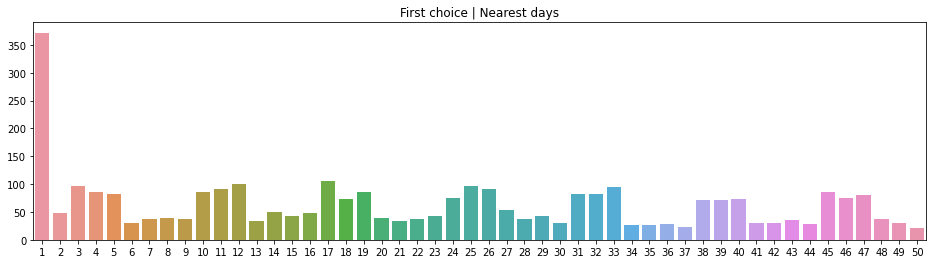

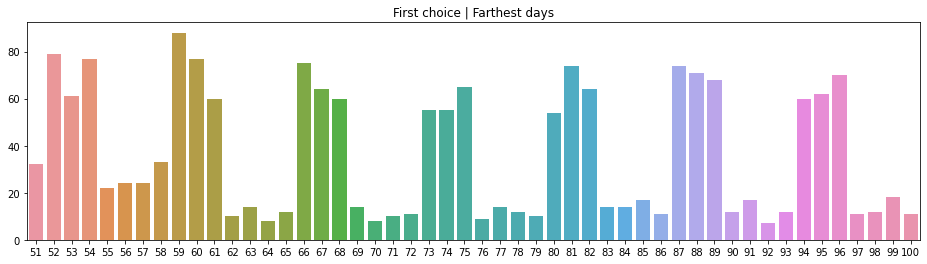

In [79]:
# Check occurrences for the first choice.
occurrences = data['choice_0'].value_counts().sort_index()

plt.figure(figsize=(16,4))
plt.title("First choice | Nearest days")
sns.barplot(x=occurrences[0:50].index, y=occurrences[0:50].values)

plt.figure(figsize=(16,4))
plt.title("First choice | Farthest days")
sns.barplot(x=occurrences[50:100].index, y=occurrences[50:100].values)

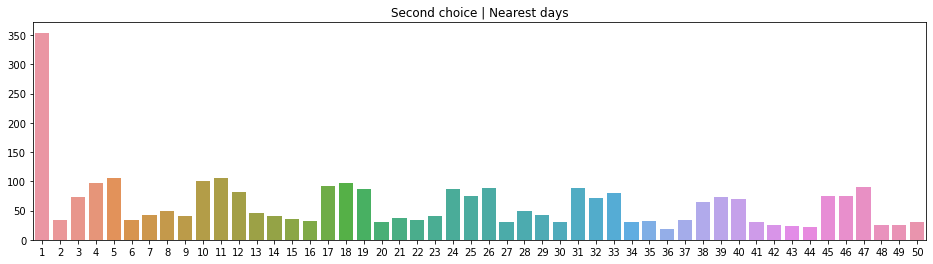

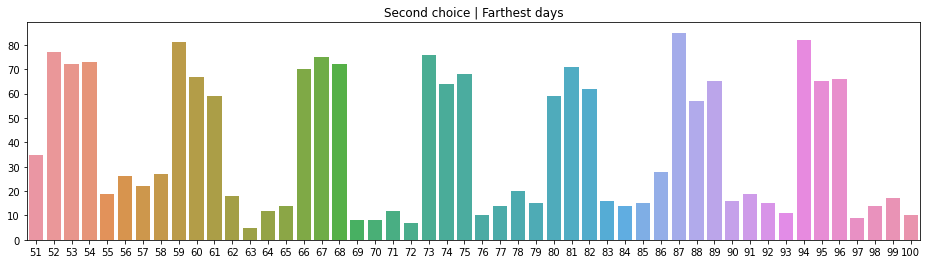

In [80]:
# Check occurrences for the second choice.
occurrences = data['choice_1'].value_counts().sort_index()

plt.figure(figsize=(16,4))
plt.title("Second choice | Nearest days")
sns.barplot(x=occurrences[0:50].index, y=occurrences[0:50].values)

plt.figure(figsize=(16,4))
plt.title("Second choice | Farthest days")
sns.barplot(x=occurrences[50:100].index, y=occurrences[50:100].values)

## 3. Build models

In [119]:
# Define constants.
COLUMNS = [f'choice_{i}' for i in range(10)]

N_DAYS = 100
MAX_OCCUPANCY = 300
MIN_OCCUPANCY = 125

DAYS_LIST = list(range(N_DAYS, 0, -1)) # From 100 to 1

GIFT_CARD = [0, 50, 50, 100, 200, 200, 300, 300, 400, 500, 500]
BUFFET = [0, 0, 9, 9, 9, 18, 18, 36, 36, 36, 36]
HELICOPTER = [0, 0, 0, 0, 0, 0, 0, 0, 0, 199, 398]

# Define auxiliary dictionaries and functions.
family_size_dict = data[['n_people']].to_dict()['n_people']
choice_dict = data[COLUMNS].to_dict()

def calc_daily_occupancy(prediction):
    daily_occupancy = {k:0 for k in DAYS_LIST}
    
    for family_index, assigned_day in enumerate(prediction):
        family_people = family_size_dict[family_index]
        daily_occupancy[assigned_day] += family_people
        
    return daily_occupancy
    
# Define cost formulas.
def calc_preference_cost(choice, family_members):
    cost = 0
    cost += GIFT_CARD[choice]
    cost += BUFFET[choice] * family_members
    cost += HELICOPTER[choice] * family_members
    return cost

def calc_accounting_cost(daily_occupancy):
    # The first day (day 100) is treated special.
    accounting_cost = (daily_occupancy[DAYS_LIST[0]]-125.0) / 400.0 * daily_occupancy[DAYS_LIST[0]]**(0.5)
    
    # Use the max function because the soft constraints might allow occupancy to dip below 125.
    accounting_cost = max(0, accounting_cost)
    
    # Loop over the rest of the days, keeping track of previous count.
    yesterday_count = daily_occupancy[DAYS_LIST[0]]
    for day in DAYS_LIST[1:]:
        today_count = daily_occupancy[day]
        diff = abs(today_count - yesterday_count)
        accounting_cost += max(0, (daily_occupancy[day]-125.0) / 400.0 * daily_occupancy[day]**(0.5 + diff / 50.0))
        yesterday_count = today_count

    return accounting_cost
    
def calc_score(prediction):
    penalty = 0;
                 
    # Define an array to count the number of people scheduled each day.
    daily_occupancy = {k:0 for k in DAYS_LIST}
    
    # Loop over each family.
    for family_index, assigned_day in enumerate(prediction):
        # Add the family member count to the daily occupancy.
        family_people = family_size_dict[family_index]
        daily_occupancy[assigned_day] += family_people

        # Check which choice was selected.
        choice = 10
        for index, column in enumerate(COLUMNS):
            if assigned_day == choice_dict[column][family_index]:
                 choice = index
                 
        # Calculate the penalty for not getting top preference
        penalty += calc_preference_cost(choice, family_people)

    # For each date, check total occupancy (using soft constraints instead of hard ones).
    for _, occuppancy in daily_occupancy.items():
        if (occuppancy > MAX_OCCUPANCY) or (occuppancy < MIN_OCCUPANCY):
            penalty += 100000000

    # Calculate the accounting cost.
    penalty += calc_accounting_cost(daily_occupancy)

    return penalty

# Check score of sample submission.
sample_pred = sample_submission['assigned_day'].tolist()
sample_score = calc_score(sample_pred)
print("Sample submission:", locale.format_string("%d", sample_score, grouping=True))

Sample submission: 10,641,498


### 3.1 Improve sample submission

In [131]:
# Start with the sample submission values.
improved_sample_pred = sample_pred.copy()

# Calculate daily occupancy.
daily_occupancy = calc_daily_occupancy(improved_sample_pred)
accounting_cost = calc_accounting_cost(daily_occupancy)

# Iterate over each family.
for family_index, assigned_day in enumerate(improved_sample_pred): 
    family_people = family_size_dict[family_index]
    
    # Check which choice was selected and calculate current preference cost.
    assigned_choice = 10
    for index, column in enumerate(COLUMNS):
        if assigned_day == choice_dict[column][family_index]:
             assigned_choice = index
    preference_cost = calc_preference_cost(assigned_choice, family_people)
    
    # Iterate over choices to check if the family can be relocated.
    for new_choice in range(10):
        new_day = choice_dict[f'choice_{pick}'][family_index]

        # Check if current day won't get too unocuppied and if new day won't get too crowded.
        can_move_out = (daily_occupancy[assigned_day] - family_people) > MIN_OCCUPANCY
        can_move_in = (daily_occupancy[new_day] + family_people) < MAX_OCCUPANCY
        
        if new_choice != assigned_choice and can_move_out and can_move_in:            
            # Check if the overall cost would be decreased.
            new_preference_cost = calc_preference_cost(choice, family_people)

            new_occupancy = daily_occupancy.copy()
            new_occupancy[assigned_day] -= family_people
            new_occupancy[new_day] += family_people
            new_accounting_cost = calc_accounting_cost(new_occupancy)

            if (new_preference_cost + new_accounting_cost) < (preference_cost + accounting_cost):
                # Update prediction, occupancy and costs.
                improved_sample_pred[family_index] = new_day
                daily_occupancy = new_occupancy
                
                # Exit loop and continue with next family.
                break

print("Sample submission improved:", locale.format_string("%d", improved_sample_score, grouping=True))

Sample submission improved: 5,023,409


## 4. Make predictions

In [130]:
# Generate the submission file (to be uploaded to Kaggle).
output = pd.DataFrame({'family_id': sample_submission['family_id'], 'assigned_day': improved_sample_pred})
output.to_csv('my_submission.csv', index=False)
print("The submission was successfully saved!")

The submission was successfully saved!
